In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "NF-YC"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn002431,MKKSSDDVKMISGEAPIVFAKACELFIEELTKSSWTMTLQAKRRTL...,85,1
1,Achn024831,MNSLEIYPKSLTSRYRIIGANFQIRKKNINPLQNINSAPNLHREQR...,581,1
2,Achn051701,MDQPEQTQQQQQQPVIGVVAGVGPMAYASPPYHSAPMGASGAPAVA...,273,1
3,Achn056131,MRQAGAYSGIASGGISGRTGPHSLPLARIKKIMNNSSDDVKMISGD...,299,1
4,Achn083431,MDIMDQQGHGHPQGAGVVGSAAQLHYGTSQYEPNQVNGTPNQGPVV...,266,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
4125,0.003185,0.000000,0.009554,0.003185,0.000000,0.003185,0.000000,0.000000,0.003185,0.000000,...,0.009554,0.003185,0.003185,0.0,0.009554,0.0,0.003185,0.0,0.0,0.000000
1716,0.035088,0.000000,0.003509,0.007018,0.000000,0.003509,0.000000,0.000000,0.007018,0.010526,...,0.003509,0.003509,0.000000,0.0,0.003509,0.0,0.000000,0.0,0.0,0.000000
900,0.041096,0.004566,0.009132,0.009132,0.000000,0.013699,0.004566,0.009132,0.004566,0.000000,...,0.000000,0.004566,0.004566,0.0,0.004566,0.0,0.000000,0.0,0.0,0.004566
2092,0.007905,0.003953,0.007905,0.007905,0.000000,0.011858,0.000000,0.003953,0.000000,0.000000,...,0.000000,0.011858,0.000000,0.0,0.000000,0.0,0.003953,0.0,0.0,0.000000
689,0.011811,0.003937,0.007874,0.007874,0.007874,0.000000,0.003937,0.003937,0.003937,0.000000,...,0.000000,0.003937,0.003937,0.0,0.007874,0.0,0.003937,0.0,0.0,0.007874


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3892, 441)
X_test: (974, 441)
y_train: (3892,)
y_test: (974,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 22s 474ms/step - accuracy: 0.5312 - loss: 0.6932

34/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6744 - loss: 0.6743   

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7225 - loss: 0.6435 - val_accuracy: 0.9538 - val_loss: 0.1775


Epoch 2/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1918

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9543 - loss: 0.1507

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1424 - val_accuracy: 0.9743 - val_loss: 0.0756


Epoch 3/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.0862

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9777 - loss: 0.0624

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9766 - loss: 0.0651 - val_accuracy: 0.9833 - val_loss: 0.0564


Epoch 4/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.0877

33/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9789 - loss: 0.0609

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9808 - loss: 0.0580 - val_accuracy: 0.9782 - val_loss: 0.0662


Epoch 5/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0284

30/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.0375

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.0416 - val_accuracy: 0.9872 - val_loss: 0.0364


Epoch 6/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0089

30/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9861 - loss: 0.0412

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0388 - val_accuracy: 0.9884 - val_loss: 0.0457


Epoch 7/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0170

30/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0212

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0215 - val_accuracy: 0.9872 - val_loss: 0.0419


Epoch 8/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0435

30/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0179

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0195 - val_accuracy: 0.9884 - val_loss: 0.0391


Epoch 9/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0232

30/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0155

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0153 - val_accuracy: 0.9859 - val_loss: 0.0390


Epoch 10/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0841

32/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0188

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0175 - val_accuracy: 0.9820 - val_loss: 0.0461


Epoch 11/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0034

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0135

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0135 - val_accuracy: 0.9846 - val_loss: 0.0437


Epoch 12/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0037

30/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0070

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0090 - val_accuracy: 0.9833 - val_loss: 0.0621


Epoch 13/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0049

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0131

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0148 - val_accuracy: 0.9859 - val_loss: 0.0447


Epoch 14/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0039

30/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0055

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0067 - val_accuracy: 0.9833 - val_loss: 0.0576


Epoch 15/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0115

31/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0190

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0195 - val_accuracy: 0.9846 - val_loss: 0.0564


Epoch 16/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0035

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0134

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0138 - val_accuracy: 0.9846 - val_loss: 0.0430



[Train Accuracy: 99.49% - Test Accuracy: 98.36%]


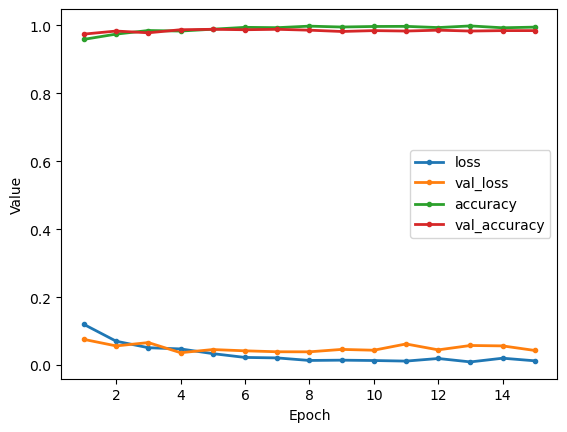

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
4125,0.000000,0.0,0.003195,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1716,0.021127,0.0,0.000000,0.003521,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
900,0.018349,0.0,0.000000,0.000000,0.000000,0.013761,0.0,0.009174,0.0,0.0,...,0.0,0.004587,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2092,0.003968,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.003968,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
689,0.003953,0.0,0.000000,0.000000,0.003953,0.000000,0.0,0.003953,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.003953,0.0,0.0,0.003953


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3892, 8701)
X_test: (974, 8701)
y_train: (3892,)
y_test: (974,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,227,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,977 (8.66 MB)

 Trainable params: 2,270,977 (8.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 22s 476ms/step - accuracy: 0.4688 - loss: 0.6931

 9/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4838 - loss: 0.6928   

18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5830 - loss: 0.6909

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6485 - loss: 0.6861

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6925 - loss: 0.6765

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7253 - loss: 0.6600

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7399 - loss: 0.6485 - val_accuracy: 0.9705 - val_loss: 0.1352


Epoch 2/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9688 - loss: 0.1462

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9602 - loss: 0.1363 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9693 - loss: 0.1113

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9742 - loss: 0.0963

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9772 - loss: 0.0859

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9791 - loss: 0.0792

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9801 - loss: 0.0757 - val_accuracy: 0.9897 - val_loss: 0.0335


Epoch 3/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0026

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0065 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0073

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0075

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0075

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0075

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9991 - loss: 0.0074 - val_accuracy: 0.9846 - val_loss: 0.0513


Epoch 4/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0037

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9955 - loss: 0.0094 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9966 - loss: 0.0080

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.0070

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0063

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9980 - loss: 0.0058

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9981 - loss: 0.0056 - val_accuracy: 0.9923 - val_loss: 0.0294


Epoch 5/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0010

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.3501e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4220e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4725e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4321e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.2061e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1556e-04 - val_accuracy: 0.9923 - val_loss: 0.0292


Epoch 6/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.1742e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3585e-04 

18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7668e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9764e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3807e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.6054e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6778e-04 - val_accuracy: 0.9949 - val_loss: 0.0285


Epoch 7/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0017

 9/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4300e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9563e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 8.5190e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0011    

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0011

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9949 - val_loss: 0.0316


Epoch 8/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.0834e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4672e-04 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 6.8325e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9996 - loss: 9.6376e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9995 - loss: 0.0014    

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0016

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0016 - val_accuracy: 0.9910 - val_loss: 0.0330


Epoch 9/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.8326e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1330e-04 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9416e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9516e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8761e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7944e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7576e-04 - val_accuracy: 0.9923 - val_loss: 0.0301


Epoch 10/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.3544e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3084e-04 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2579e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1980e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1610e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1401e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1286e-04 - val_accuracy: 0.9923 - val_loss: 0.0319


Epoch 11/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.3167e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.5250e-05 

18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.9167e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.7345e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5454e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4155e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4013e-05 - val_accuracy: 0.9923 - val_loss: 0.0326


Epoch 12/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.8617e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3029e-05 

18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1706e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1360e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2173e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3211e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3885e-05 - val_accuracy: 0.9923 - val_loss: 0.0331


Epoch 13/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.8803e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0818e-05 

18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1466e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6356e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0125e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1798e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2179e-05 - val_accuracy: 0.9923 - val_loss: 0.0328


Epoch 14/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.0148e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.3640e-05 

18/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9240e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7618e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6831e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0897e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.2315e-05 - val_accuracy: 0.9936 - val_loss: 0.0298


Epoch 15/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 9.5200e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4032e-05 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7532e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4045e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2177e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0819e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0107e-05 - val_accuracy: 0.9923 - val_loss: 0.0319


Epoch 16/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.2575e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5511e-05 

19/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9831e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6175e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4466e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3802e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3555e-05 - val_accuracy: 0.9923 - val_loss: 0.0324



[Train Accuracy: 100.00% - Test Accuracy: 99.59%]


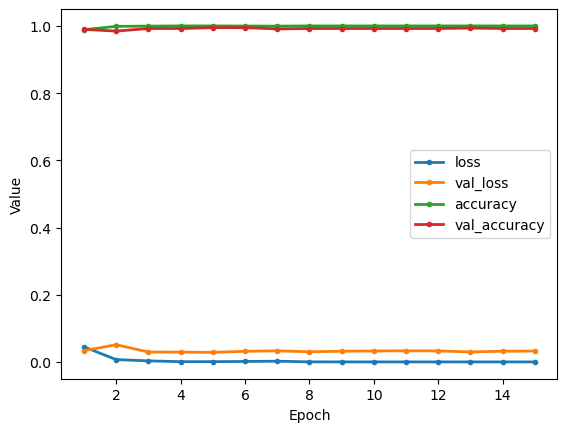

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
4125,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1716,0.010601,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
900,0.000000,0.0,0.0,0.0,0.0,0.009217,0.0,0.009217,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2092,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.003984,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
689,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.003968,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003968,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      35,366,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,407,361 (135.07 MB)

 Trainable params: 35,407,361 (135.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 31s 658ms/step - accuracy: 0.4688 - loss: 0.6932

 2/49 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.4844 - loss: 0.6931 

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.4861 - loss: 0.6931

 4/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4847 - loss: 0.6931

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.4834 - loss: 0.6931

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.4827 - loss: 0.6931

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4836 - loss: 0.6930

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4839 - loss: 0.6929

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.4840 - loss: 0.6927

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.4840 - loss: 0.6926

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4846 - loss: 0.6925

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4858 - loss: 0.6923

13/49 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.4891 - loss: 0.6922

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.4937 - loss: 0.6920

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.4994 - loss: 0.6918

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5057 - loss: 0.6916

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5125 - loss: 0.6913

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5196 - loss: 0.6910

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5267 - loss: 0.6907

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5339 - loss: 0.6904

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5410 - loss: 0.6900

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5481 - loss: 0.6896

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5551 - loss: 0.6892

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5620 - loss: 0.6888

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5686 - loss: 0.6883

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5751 - loss: 0.6878

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5814 - loss: 0.6872

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5876 - loss: 0.6866

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5936 - loss: 0.6859

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5994 - loss: 0.6852

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6050 - loss: 0.6845

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.6105 - loss: 0.6837

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6159 - loss: 0.6828

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6210 - loss: 0.6819

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6261 - loss: 0.6809

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6309 - loss: 0.6799

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6356 - loss: 0.6788

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6402 - loss: 0.6777

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6446 - loss: 0.6765

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6489 - loss: 0.6752

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6532 - loss: 0.6738

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6573 - loss: 0.6724

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6612 - loss: 0.6709

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6651 - loss: 0.6694

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6689 - loss: 0.6678

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6726 - loss: 0.6661

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6761 - loss: 0.6643

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6796 - loss: 0.6625

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.6829 - loss: 0.6607

49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.6861 - loss: 0.6590 - val_accuracy: 0.9641 - val_loss: 0.2450


Epoch 2/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9844 - loss: 0.2333

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9883 - loss: 0.2228

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9905 - loss: 0.2183

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9909 - loss: 0.2145

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9908 - loss: 0.2120

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9906 - loss: 0.2086

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9907 - loss: 0.2046

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9909 - loss: 0.2006

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9911 - loss: 0.1965

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9914 - loss: 0.1925

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9913 - loss: 0.1890

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9912 - loss: 0.1856

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9913 - loss: 0.1822

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9913 - loss: 0.1790

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9914 - loss: 0.1758

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9915 - loss: 0.1729

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9915 - loss: 0.1700

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9916 - loss: 0.1673

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9916 - loss: 0.1646

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9917 - loss: 0.1620

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9918 - loss: 0.1594

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9918 - loss: 0.1570

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9919 - loss: 0.1546

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9919 - loss: 0.1523

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9920 - loss: 0.1501

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9920 - loss: 0.1481

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9920 - loss: 0.1461

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9921 - loss: 0.1442

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9921 - loss: 0.1423

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9921 - loss: 0.1406

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9921 - loss: 0.1388

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9922 - loss: 0.1372

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9922 - loss: 0.1355

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9923 - loss: 0.1339

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9923 - loss: 0.1324

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9923 - loss: 0.1309

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9923 - loss: 0.1294

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.9924 - loss: 0.1280

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9924 - loss: 0.1266

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9924 - loss: 0.1252

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9925 - loss: 0.1239

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9925 - loss: 0.1226

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9925 - loss: 0.1214

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9925 - loss: 0.1202

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9925 - loss: 0.1190

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9925 - loss: 0.1178

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9925 - loss: 0.1167

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9925 - loss: 0.1156

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9925 - loss: 0.1146

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9925 - loss: 0.1136 - val_accuracy: 0.9936 - val_loss: 0.0311


Epoch 3/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 0.0095

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 1.0000 - loss: 0.0098

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 0.0095

 4/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 0.0092

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9994 - loss: 0.0094

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9990 - loss: 0.0094

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.9989 - loss: 0.0093

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9988 - loss: 0.0092

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9987 - loss: 0.0091

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.9987 - loss: 0.0090

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9987 - loss: 0.0089

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9987 - loss: 0.0088

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9987 - loss: 0.0087

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9987 - loss: 0.0086

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9987 - loss: 0.0085

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9987 - loss: 0.0084

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9988 - loss: 0.0084

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9988 - loss: 0.0083

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9988 - loss: 0.0082

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.9988 - loss: 0.0081

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9988 - loss: 0.0080

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9989 - loss: 0.0080

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9989 - loss: 0.0079

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9989 - loss: 0.0078

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9989 - loss: 0.0077

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9989 - loss: 0.0077

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9990 - loss: 0.0076

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9990 - loss: 0.0075

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9990 - loss: 0.0075

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9990 - loss: 0.0075

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9990 - loss: 0.0074

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9990 - loss: 0.0074

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9990 - loss: 0.0073

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9990 - loss: 0.0073

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9990 - loss: 0.0072

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9990 - loss: 0.0072

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9990 - loss: 0.0071

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9990 - loss: 0.0071

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9990 - loss: 0.0070

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9990 - loss: 0.0070

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9990 - loss: 0.0070

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9990 - loss: 0.0069

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9990 - loss: 0.0069

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9990 - loss: 0.0069

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9990 - loss: 0.0068

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9990 - loss: 0.0068

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9990 - loss: 0.0067

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9990 - loss: 0.0067

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9990 - loss: 0.0067

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9991 - loss: 0.0066 - val_accuracy: 0.9795 - val_loss: 0.0443


Epoch 4/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 7.7570e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0027    

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0029

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0029

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 0.0028

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 0.0028

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 0.0027

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0026

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0025

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0025

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0024

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 0.0024

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0023

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0023

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0022

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0022

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0021

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 0.0021

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 0.0021

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 0.0021

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 0.0020

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 0.0020

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 0.0020

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 0.0019

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 0.0019

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 0.0019

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 0.0019

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 0.0019

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 0.0018

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 0.0018

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 0.0018

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0018

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0018

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0018

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0017

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0017

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0017

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0017

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0017

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0017

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0017

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0016

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0016

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0016

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0016

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0016

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0016

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0016

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 0.0016

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9782 - val_loss: 0.0471


Epoch 5/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 8.8757e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 7.7079e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 7.2395e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 6.8322e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 6.5563e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 6.3376e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 6.1667e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.9927e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 5.8692e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.7626e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 5.6729e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.6082e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 5.8787e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 6.0758e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 6.2327e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 6.3552e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 6.4459e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 6.5133e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 6.5690e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 6.6108e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 6.6424e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 6.6648e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.6776e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.6866e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.6898e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.6891e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.6847e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.6843e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.6794e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.6713e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 6.6600e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.6466e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.6306e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.6152e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.6001e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.5831e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.5645e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.5463e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.5271e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.5084e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 6.4908e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 6.4735e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 6.4555e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 6.4365e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 6.4184e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 6.4027e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 6.3867e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 6.3705e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 6.3544e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 6.3390e-04 - val_accuracy: 0.9807 - val_loss: 0.0400


Epoch 6/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.0193e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 4.6046e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 7.5607e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 8.3385e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 8.5190e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 8.4815e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 8.3291e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 8.1850e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 8.0575e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 7.9220e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 7.8320e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 7.7223e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 7.6167e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 7.5024e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 7.3859e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 7.2803e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 7.2420e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 7.1977e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 1.0000 - loss: 7.1470e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 7.0949e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 7.0377e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.9821e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.9272e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.8697e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.8119e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.7520e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.6926e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.6333e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.5735e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 6.5140e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.4559e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.3985e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.3442e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.2918e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.2409e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 6.1941e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.1493e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.1049e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.0612e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 6.0190e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.9768e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.9352e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.8978e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.8605e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.8254e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.7954e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.7653e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.7365e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 5.7081e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 5.6808e-04 - val_accuracy: 0.9807 - val_loss: 0.0432


Epoch 7/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 3.2650e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 3.2989e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 3.1603e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 3.0147e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 2.9608e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.9184e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 2.8638e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 2.8153e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.7669e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 2.7293e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 2.6940e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 2.6641e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 2.6354e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.6121e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.5977e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.5817e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.5712e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.8140e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 3.0238e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 3.1996e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 3.3461e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 1.0000 - loss: 3.4705e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 3.5771e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 3.6672e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 3.7461e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 3.8135e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 3.8718e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 3.9220e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 1.0000 - loss: 3.9653e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.0045e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 4.0378e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.0706e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.0995e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.1256e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.1481e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.1682e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.1862e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.2016e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.2147e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 4.2258e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.2383e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.2484e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.2575e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 4.2653e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.2713e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.2759e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.2794e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 4.2822e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 1.0000 - loss: 4.2841e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 4.2860e-04 - val_accuracy: 0.9846 - val_loss: 0.0298


Epoch 8/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.8743e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 1.9554e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 2.0066e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 1.9508e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 1.9126e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.8682e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.8740e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.8681e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.8608e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.8617e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.8561e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.8510e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 1.8573e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 1.8573e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.8525e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.8463e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.8390e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.8343e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.8297e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.8237e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.8180e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.8125e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.8067e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.8013e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.7988e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.7977e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.7952e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.7916e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.7883e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.7842e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.7795e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.7740e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.7685e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.7627e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.7570e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 1.7508e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 1.7454e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 1.7405e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 1.7358e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 1.7311e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.7264e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.7220e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.7177e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.7130e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.7090e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.7050e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.7008e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.6973e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.6941e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 1.6910e-04 - val_accuracy: 0.9782 - val_loss: 0.0498


Epoch 9/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 1.0000 - loss: 5.1879e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 1.0000 - loss: 4.1501e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 3.6675e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 3.4378e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 3.2366e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 1.0000 - loss: 3.2700e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 3.2432e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 3.2509e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 3.2286e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 3.1924e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 3.1472e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 3.0971e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 3.0471e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.9971e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 2.9627e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.9245e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.8926e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.8594e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.8281e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 2.7971e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.7658e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 2.7350e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 2.7054e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 2.6777e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 2.6515e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 2.6260e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 2.6014e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 2.5768e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.5521e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 2.5277e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 2.5041e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.4816e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.4594e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.4381e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.4176e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.3977e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.3786e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.3599e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.3414e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 2.3255e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.3104e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.2954e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.2817e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.2681e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.2550e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 2.2419e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 2.2298e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 2.2180e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 1.0000 - loss: 2.2064e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 2.1952e-04 - val_accuracy: 0.9820 - val_loss: 0.0428


Epoch 10/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 6.2132e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 7.2097e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 8.6092e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 9.3278e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 9.5512e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 9.5892e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 9.6102e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 9.7580e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 9.8324e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 9.8390e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.0085e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.0269e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.0417e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.0507e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.0558e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.0579e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 1.0000 - loss: 1.0597e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.0605e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.0593e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.0574e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.0552e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.0526e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.0502e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.0475e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.0440e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.0401e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.0361e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.0319e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.0273e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.0224e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 1.0000 - loss: 1.0175e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.0124e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 1.0084e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.0045e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 1.0008e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 9.9725e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 9.9356e-05

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 9.8980e-05

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 1.0000 - loss: 9.8627e-05

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 9.8261e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 9.7889e-05

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 9.7520e-05

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 9.7143e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.6776e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.6416e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.6094e-05

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.5780e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.5453e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 9.5138e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 9.4835e-05 - val_accuracy: 0.9807 - val_loss: 0.0474


Epoch 11/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 1.0000 - loss: 3.6682e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 1.0000 - loss: 3.4440e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 1.0000 - loss: 4.2582e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 4.6248e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 4.7188e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 4.8331e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 4.8678e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.9235e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 4.9651e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 4.9884e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.0088e-05

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 5.0163e-05

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.0283e-05

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 5.0370e-05

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 5.0430e-05

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.0526e-05

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.0522e-05

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 5.0581e-05

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.0656e-05

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 5.0716e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.0736e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.0720e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0702e-05

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0679e-05

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0618e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0706e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0794e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0934e-05

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.1077e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.1270e-05

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.1441e-05

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.1590e-05

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.1706e-05

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.1864e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.2026e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.2167e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.2286e-05

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.2399e-05

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.2523e-05

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.2666e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.2808e-05

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.2928e-05

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.3048e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.3142e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.3222e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.3284e-05

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 5.3390e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 5.3493e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 5.3595e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 5.3692e-05 - val_accuracy: 0.9782 - val_loss: 0.0526


Epoch 12/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 12s 260ms/step - accuracy: 1.0000 - loss: 5.9195e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 5.6781e-05 

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 5.2995e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 5.2383e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 5.1841e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 5.1343e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 5.1483e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 5.1159e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 5.1209e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.1328e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.1333e-05

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.1216e-05

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 5.1189e-05

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.1043e-05

15/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.1069e-05

16/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.1061e-05

17/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.0963e-05

18/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 5.0903e-05

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 5.0802e-05

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.0650e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 5.0573e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 5.0483e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0348e-05

24/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0231e-05

25/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0291e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0303e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.0298e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 5.0303e-05

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0322e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0358e-05

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 1.0000 - loss: 5.0374e-05

32/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.0381e-05

33/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.0418e-05

34/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.0470e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.0489e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.0537e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.0669e-05

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.0835e-05

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.0993e-05

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 5.1155e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.1284e-05

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.1389e-05

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.1572e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.1743e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 5.1888e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 5.2016e-05

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 5.2124e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 5.2215e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 5.2299e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 5.2380e-05 - val_accuracy: 0.9807 - val_loss: 0.0486



[Train Accuracy: 100.00% - Test Accuracy: 98.77%]


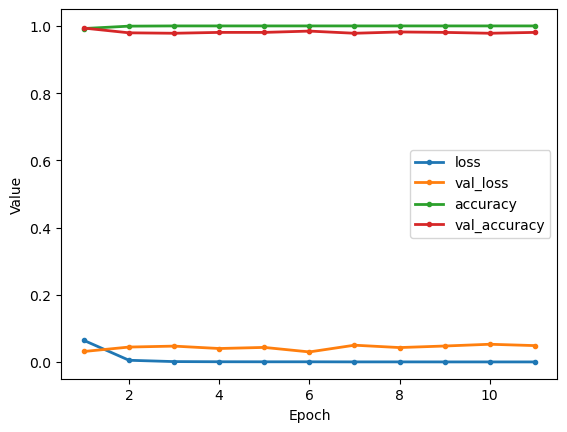

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

 7/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 7/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [25]:
report.save()

Report saved as Output/Reports/NF-YC/report_R119C4TS.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################